In [1]:
# Verify that we are using the correct Python (/home/ata/miniconda3/envs/ml/bin/)
!which python
!which jupyter

/home/ata/miniconda3/envs/ml/bin/python
/home/ata/miniconda3/envs/ml/bin/jupyter


In [1]:
# Import the class from the Python file (module)
import pandas as pd
import matplotlib.pyplot as plt
import os
from dotenv import load_dotenv
from pathlib import Path
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.seasonal import seasonal_decompose
import seaborn as sns
from BinanceClient import BinanceClient
import numpy as np
from typing import Final
import joblib
from BatchFeatures import BatchFeatures
from datetime import datetime, timedelta
%matplotlib widget

#### Fetch pair data

In [2]:
# Initialize Binance client with your API credentials
# dotenv_path = Path('.env-secret')
# load_dotenv(dotenv_path=dotenv_path)
api_secret = os.getenv("BINANCE_SECRET_KEY")
api_key = os.getenv("BINANCE_API_KEY")

# Create Binance client & initialize it
pair = "BTCUSDT"
time_delta = 12
db_name = pair + "_1min_" + str(time_delta) + "weeks.db"
binance_client = BinanceClient(db_name)
binance_client.set_interval("1m")
batch_feature = BatchFeatures()


#### Fecth Data from Binance

In [5]:

# Create connection to fetch data
binance_client.make(api_key, api_secret)

# Get current server time
server_time = binance_client.get_server_time()

# Compute start and end time for the last x hours
server_time_dt = datetime.fromtimestamp(server_time['serverTime'] / 1000, tz=datetime.timezone.utc if hasattr(datetime, 'timezone') else None)
end_date = server_time_dt
# start_date = server_time_dt - timedelta(hours=10)
start_date = server_time_dt - timedelta(weeks=time_delta)
start_date_str = int(start_date.timestamp() * 1000)  # Convert to milliseconds
end_date_str = int(end_date.timestamp() * 1000)      # Convert to milliseconds

# Fetch data
data = binance_client.fetch_data(pair, start_date_str, end_date_str)
binance_client.store_data_to_db(pair, data)

# Check if data is fetched
if not data.empty:
    df = data
else:
    print("No data found!!!.")

Fetching data from Binance API...


#### Fetch data from db

In [3]:
#Fetch data from db
df = binance_client.fetch_data_from_db(pair)

#### Define target 

In [4]:
# Predict the percentage price change over the next 'n' candles
nn = 10
df['target'] = (df['close'].shift(nn) - df['close']) / df['close'] * 100
df.dropna(inplace=True)

#### Feature Reduction

In [ ]:
# Identify highly correlated features
threshold = 0.95  # Adjust threshold as needed
corr_matrix = df.corr()
upper_triangle = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Find features to drop
to_drop = [column for column in upper_triangle.columns if any(upper_triangle[column] > threshold)]

# Drop the features
df_reduced = df.drop(columns=to_drop)
print(f"Dropped features: {to_drop}")


Dropped features: ['high', 'low', 'close', 'sma_10', 'sma_50', 'ema_10', 'macd_signal', 'bollinger_upper', 'bollinger_lower', 'close_lag_1', 'close_lag_3', 'macd_lag_1']


#### Feature engineering

In [5]:
# Feature Engineering (mind the order since some features are depended on others)
bf = BatchFeatures()
bf.calculate_sma(df)
bf.calculate_ema(df)
bf.calculate_rsi(df)
bf.calculate_macd(df)
bf.calculate_bollinger_bands(df)
bf.calculate_atr(df)
bf.calculate_volume_features(df)
bf.calculate_roc(df)
bf.calculate_lagged_features(df)
bf.calculate_candle_features(df)
bf.calculate_stochastic_oscillator(df)
bf.calculate_williams_r(df)
bf.calculate_moving_average_crossover(df)
bf.calculate_historical_volatility(df)
bf.calculate_on_balance_volume(df)
bf.calculate_money_flow_index(df)


#### Test/Train Splot

In [6]:
# drop NaNs
df.dropna(inplace=True)

# df is sorted by time and indexed by a datetime index
n = len(df)
train_end = int(n * 0.8) # 80% data used for training
train_df = df.iloc[:train_end]
test_df = df.iloc[train_end:]

# Separate features and target
X_train = train_df.drop(['target'], axis=1)
y_train = train_df['target']

X_test = test_df.drop(['target'], axis=1)
y_test = test_df['target']


In [ ]:
plt.clf()
plt.figure(figsize=(12, 6))
plt.plot(train_df['close'], label="Actual", alpha=0.8)

#### Grid Search for Hyperparameter Tuning 

In [10]:
from xgboost import XGBRegressor
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV

pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Scaling step
    ('regressor', RandomForestRegressor())  # Model
])

# Define hyperparameter grid for the regressor
param_grid = {
    'regressor__n_estimators': [10, 50, 100],
    'regressor__max_depth': [3, 5, 10],
    'regressor__max_features': [5, 10, 15],
    'regressor__bootstrap': [True, False]
}



# Use TimeSeriesSplit for cross-validation
time_series_split = TimeSeriesSplit(n_splits=5)

# Perform grid search with pipeline
grid_search = GridSearchCV(
    pipeline,
    param_grid,
    scoring='neg_mean_squared_error',
    cv=time_series_split,
    return_train_score=True,
    verbose=3
)

# Fit the pipeline
grid_search.fit(X_train, y_train)


Fitting 5 folds for each of 54 candidates, totalling 270 fits


ValueError: Invalid parameter 'bootstrap' for estimator Pipeline(steps=[('scaler', StandardScaler()),
                ('regressor', RandomForestRegressor())]). Valid parameters are: ['memory', 'steps', 'transform_input', 'verbose'].

#### Save GridSearch Results

In [ ]:

# Save the GridSearchCV object
joblib.dump(grid_search, 'grid_search_results_1min_nn10.pkl')

['grid_search_results_1min_nn10.pkl']

#### Load saves GridSearch results

In [ ]:

# Load GridSearch results
grid_search = joblib.load('grid_search_results_1sec_nn12.pkl')
# grid_search = joblib.load('grid_search_results.pkl')


#### Load saves GridSearch results

In [12]:
# Load GridSearch results
grid_search = joblib.load('grid_search_results_1min_reduced.pkl')
# grid_search = joblib.load('grid_search_results.pkl')


#### Analyse grid search results

In [18]:
# Access best parameters or results
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)
best_score = grid_search.best_score_

# Best model
best_model = grid_search.best_estimator_


Best Parameters: {'regressor__bootstrap': False, 'regressor__max_depth': 10, 'regressor__max_features': 15, 'regressor__n_estimators': 50}
Best Score: -0.001007909903643664


In [20]:
rmse = (-best_score) ** 0.5
print(f"RMSE: {rmse}")

RMSE: 0.0317475968168248


In [23]:
std_dev = np.std(y_train)
print(f"Target Std Dev: {std_dev}")

Target Std Dev: 0.228593638065057


In [21]:
mean_y = np.abs(y_train.mean())
relative_error = rmse / mean_y
print(f"Relative RMSE: {relative_error:.2%}")


Relative RMSE: 1294.52%


#### Best Model Training

In [26]:
from sklearn.ensemble import RandomForestRegressor

# Extract best parameters from GridSearchCV
best_params = grid_search.best_params_

# Remove 'regressor__' prefix to pass parameters directly to the model
model_params = {key.replace('regressor__', ''): value for key, value in best_params.items()}

# Train the model using the best parameters
best_model = RandomForestRegressor(**model_params)

# NOTE: Feature scaling is not requiredfor Random Forest regressor
best_model.fit(X_train, y_train)

# Get feature importances
feature_importances = best_model.feature_importances_

# Create a DataFrame for better visualization
feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': feature_importances
})

# Sort features by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Display the top 10 features
print(feature_importance_df.head(10))

            Feature  Importance
16           roc_10    0.748915
10        macd_hist    0.160671
7            rsi_14    0.048615
8              macd    0.026003
13           atr_14    0.007611
3            volume    0.003261
9       macd_signal    0.002428
14     volume_ma_20    0.000625
12  bollinger_lower    0.000612
5            sma_50    0.000330


In [27]:
# Save the model
joblib.dump(best_model, 'best_model_10candles_1min.joblib')

['best_model_10candles_1min.joblib']

In [10]:
# load the best model
best_model = joblib.load('best_model_10candles_1min.joblib')

#### Best Model Prediction

In [92]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Predict on test data
y_pred = best_model.predict(X_test)

# Calculate metrics
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error (MSE):", mse)
print("Mean Absolute Error (MAE):", mae)
print("R² Score:", r2)


Mean Squared Error (MSE): 8.054875189884505e-05
Mean Absolute Error (MAE): 0.001565382706384811
R² Score: 0.9985618836087452


#### Generate Predictions

In [32]:
# Use the model's predictions
predictions = pd.DataFrame(y_pred)  # Predicted percentage changes
y_pred_train  = pd.DataFrame(best_model.predict(X_train))  # Predicted percentage changes

### Trading Signal Generation & Back Testing

In [39]:
INITIAL_BALANCE = 100  # Starting with $10,000

##### Trade Simulator

In [34]:
def simulate_trades(signals, prices, initial_balance=1000):
    """
    Simulates trades based on signals and actual price changes.

    Args:
        actual_changes (list or pd.Series): Actual percentage changes (not predicted).
        signals (list): List of trading signals ("Buy", "Sell", "Hold").
        prices (list or pd.Series): Actual price values for the asset.
        initial_balance (float): Starting balance of the trading account.

    Returns:
        float: Final balance or cumulative profit.
    """
    balance = INITIAL_BALANCE
    position = 0  # Tracks the number of stocks held
    entry_price = None  # Store the price when a "Buy" was executed
    
    for i, signal in enumerate(signals):
        if signal == "Buy" and balance > 0:
            # Execute a buy
            entry_price = prices.iloc[i]  # Use .iloc for positional indexing
            position = balance / entry_price  # Buy with all available balance
            balance = 0  # All balance used to buy
        elif signal == "Sell" and position > 0:
            # Execute a sell
            exit_price = prices.iloc[i]  # Use .iloc for positional indexing
            balance = position * exit_price  # Convert position to cash
            position = 0  # Clear position
            entry_price = None  # Reset entry price after selling

    # If there's a remaining position at the end, calculate its value
    if position > 0 and entry_price is not None:
        balance += position * prices.iloc[-1]  # Use .iloc for positional indexing

    return balance - INITIAL_BALANCE  # Return cumulative profit


#### Trade Signal Generation

##### Advance Trade Signal Generation

**Generate a Search Space**

In [61]:
import numpy as np
buy_thresholds = np.arange(-2.0, -0.031, 0.01)
sell_thresholds = np.arange(0.01, 2.0, 0.01)

# Add signals to a DataFrame for analysis
results_df = X_test.copy()
# results_df['Predicted Change'] = predictions.shift(-nn).values
results_df['Predicted Change'] = predictions.values
# Compute predicted prices based on the previous close and Predicted Change
results_df['Predicted Price'] = results_df['close_lag_1'] * (1 + results_df['Predicted Change'] / 100)

In [ ]:
plt.clf()
plt.figure(figsize=(12, 6))
plt.plot(results_df['Predicted Price'], label="Predicted", alpha=0.8)
plt.plot(test_df['close'], label="Actual", alpha=0.8)
plt.legend()
plt.title("Actual vs. Predicted Stock Price Changes (Next Hour)")
plt.xlabel("Time Steps")
plt.ylabel("Percentage Change")
plt.show()


##### Evaluate Thresholds

In [37]:
best_buy_threshold = None
best_sell_threshold = None
best_performance = -np.inf

ii = 0
jj = 0
performance = np.zeros((len(buy_thresholds), len(sell_thresholds)))

for buy_th in buy_thresholds:
    for sell_th in sell_thresholds:
        # Generate signals
        trading_signals = [
            "Buy" if pred < buy_th else "Sell" if pred > sell_th else "Hold"
            for pred in results_df['Predicted Change'].values
        ]
        
        # Simulate trades and calculate performance
        performance[ii, jj] = simulate_trades(
            signals=trading_signals,
            prices=results_df['Predicted Price'],  # Use the computed predicted prices
            initial_balance=INITIAL_BALANCE
        )
        # Update best thresholds if current performance is better
        if performance[ii, jj] > best_performance:
            best_performance = performance[ii, jj]
            best_buy_threshold = buy_th
            best_sell_threshold = sell_th
        jj += 1
    ii += 1
    jj = 0
print(f"Best Buy Threshold: {best_buy_threshold}, Best Sell Threshold: {best_sell_threshold}")
print(f"Best Performance: {best_performance}")


Best Buy Threshold: -0.13999999999999835, Best Sell Threshold: 0.09
Best Performance: 674217.3630776572


#### Beck Testing 

In [97]:
# Define buy & sell thrsholds
buy_threshold = -0.13999999999999835
sell_threshold = 0.09
# Generate signals with reversed logic
trading_signals = [
    "Buy" if pred < buy_threshold else "Sell" if pred > sell_threshold else "Hold"
    for pred in results_df['Predicted Change']
]


# buy_threshold = 0.09
# sell_threshold = -0.13999999999999835
# Generate signals with reversed logic
# trading_signals = [
#     "Buy" if pred > buy_threshold else "Sell" if pred < sell_threshold else "Hold"
#     for pred in results_df['Predicted Change']
# ]

balance = INITIAL_BALANCE
position = 0  # No stock initially
trading_log = []  # To store completed trades



results_df['Signal'] = trading_signals

# Add 'open' and 'close' prices from the original DataFrame to results DataFrame
results_df['open'] = df.loc[results_df.index, 'open']
results_df['close'] = df.loc[results_df.index, 'close']

results_df.dropna(inplace=True)

# Variables to track ongoing trades
buy_price = None
buy_date = None
buy_volume = None

# Iterate over results_df for backtesting
for index, row in results_df.iterrows():
    signal = row['Signal']
    price = row['Predicted Price']  # Use 'open' price for Buy
    # volume = balance / price if signal == "Buy" and balance > 0 else position  # Calculate volume

    if signal == "Buy" and balance > 0:
        # Record Buy details
        buy_price = price
        buy_date = index
        buy_volume = balance / price
        position = buy_volume  # Update position
        balance = 0  # All money is invested

    elif signal == "Sell" and position > 0:
        # Calculate profit/loss for the completed trade
        sell_price = price  # Use 'close' price for Sell
        profit_loss = (sell_price - buy_price) * buy_volume
        balance = sell_price * buy_volume  # Update balance after selling
        position = 0  # No stock left

        # Record the completed trade in the log
        trading_log.append({
            "Buy Date": buy_date,
            "Buy Price": buy_price,
            "Buy Volume": buy_volume,
            "Sell Date": index,
            "Sell Price": sell_price,
            "Profit/Loss": profit_loss
        })

        # Reset Buy details
        buy_price = None
        buy_date = None
        buy_volume = None

# Final portfolio value
if position > 0:
    final_price = results_df.iloc[-1]['Predicted Price']
    final_profit_loss = (final_price - buy_price) * buy_volume
    balance = final_price * buy_volume  # Update balance with remaining shares
    trading_log.append({
        "Buy Date": buy_date,
        "Buy Price": buy_price,
        "Buy Volume": buy_volume,
        "Sell Date": results_df.index[-1],
        "Sell Price": final_price,
        "Profit/Loss": final_profit_loss
    })

# Convert trading log to a DataFrame for better analysis
trading_log_df = pd.DataFrame(trading_log)

# Print the final results
print(f"Final Balance: ${balance:.2f}")
print(f"Net Profit: ${balance - INITIAL_BALANCE:.2f}")



Final Balance: $6015.82
Net Profit: $5915.82


In [101]:
# Save the model
joblib.dump(best_model, 'best_model_10candles_reduced_1min.joblib')

['best_model_10candles_reduced_1min.joblib']

In [ ]:
# Plot the predicted prices
plt.clf()
plt.figure(figsize=(14, 7))
plt.plot(results_df.index, results_df['Predicted Change'], label='Predicted Change', color='blue', alpha=0.7)
plt.plot(results_df.index, y_test, label='Actual Change', color='red', alpha=0.7)


# Use trading_log_df for Buy and Sell points
buy_signals = trading_log_df.dropna(subset=['Buy Date'])
sell_signals = trading_log_df.dropna(subset=['Sell Date'])

# Map Buy/Sell signals to values from results_df['close']
buy_close_prices = [results_df.loc[row['Buy Date'], 'Predicted Change'] for _, row in buy_signals.iterrows()]
sell_close_prices = [results_df.loc[row['Sell Date'], 'Predicted Change'] for _, row in sell_signals.iterrows()]

# Plot Buy signals as green squares at actual 'close' prices
plt.scatter(
    buy_signals['Buy Date'],
    buy_close_prices,
    label='Buy Signal',
    color='green',
    marker='s',
    alpha=0.6
)

# Plot Sell signals as red circles at actual 'close' prices
plt.scatter(
    sell_signals['Sell Date'],
    sell_close_prices,
    label='Sell Signal',
    color='red',
    marker='o',
    alpha=0.6
)

# Add labels, title, legend, and grid
plt.title("Trading Signals Over Predicted Prices (Using Actual Close Prices)")
plt.xlabel("Time")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
import matplotlib.pyplot as plt

# Add predicted prices to results_df
results_df['Predicted Price'] = results_df['close'] * (1 + results_df['Predicted Change'] / 100)

# Plot the predicted prices
plt.clf()
plt.figure(figsize=(14, 7))
plt.plot(results_df.index, results_df['Predicted Price'], label='Predicted Price', color='blue', alpha=0.7)

# Use trading_log_df for Buy and Sell points
buy_signals = trading_log_df.dropna(subset=['Buy Date'])
sell_signals = trading_log_df.dropna(subset=['Sell Date'])

# Map Buy/Sell signals to values from results_df['close']
buy_close_prices = [results_df.loc[row['Buy Date'], 'Predicted Price'] for _, row in buy_signals.iterrows()]
sell_close_prices = [results_df.loc[row['Sell Date'], 'Predicted Price'] for _, row in sell_signals.iterrows()]

# Plot Buy signals as green squares at actual 'close' prices
plt.scatter(
    buy_signals['Buy Date'],
    buy_close_prices,
    label='Buy Signal',
    color='green',
    marker='s',
    alpha=0.6
)

# Plot Sell signals as red circles at actual 'close' prices
plt.scatter(
    sell_signals['Sell Date'],
    sell_close_prices,
    label='Sell Signal',
    color='red',
    marker='o',
    alpha=0.6
)

# Add labels, title, legend, and grid
plt.title("Trading Signals Over Predicted Prices (Using Actual Close Prices)")
plt.xlabel("Time")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.show()


#### Compute Baseline

In [41]:
# Get starting and ending prices
initial_price = results_df.iloc[0]['close']  # Opening price at the first date
final_price = results_df.iloc[-1]['close']  # Closing price at the last date

# Calculate number of shares purchased with initial balance
shares = INITIAL_BALANCE / initial_price

# Calculate final balance
final_balance_baseline = shares * final_price

# Calculate profit/loss for the baseline strategy
profit_loss_baseline = final_balance_baseline - INITIAL_BALANCE

# Print results
print(f"Baseline Final Balance: ${final_balance_baseline:.2f}")
print(f"Baseline Strategy Profit/Loss: ${profit_loss_baseline:.2f}")


Baseline Final Balance: $96.54
Baseline Strategy Profit/Loss: $-3.46


#### Baseline Comparison

In [42]:
# Assuming `profit_loss_estimator` is calculated from your trading log
profit_loss_estimator = trading_log_df['Profit/Loss'].sum()

# Calculate difference and percentage improvement
difference = profit_loss_estimator - profit_loss_baseline
improvement_percentage = (difference / abs(profit_loss_baseline)) * 100 if profit_loss_baseline != 0 else None

# Print comparison
print(f"Estimator Profit/Loss: ${profit_loss_estimator:.2f}")
print(f"Difference vs. Baseline: ${difference:.2f}")
if improvement_percentage is not None:
    print(f"Performance Improvement: {improvement_percentage:.2f}%")
else:
    print("Baseline profit/loss is zero, percentage improvement cannot be calculated.")


Estimator Profit/Loss: $67421.74
Difference vs. Baseline: $67425.20
Performance Improvement: 1947511.90%


In [43]:
# Calculate momentum (percentage change in price)
momentum_threshold = 0.01  # 1% change as momentum threshold
momentum_signals = results_df['close'].pct_change()  # Calculate percentage change
momentum_trades = momentum_signals[momentum_signals.abs() > momentum_threshold]

# Initialize profit/loss calculation for momentum strategy
momentum_profit_loss = 0
balance = INITIAL_BALANCE
position = 0

# Iterate through momentum trades
for idx, change in momentum_trades.items():  # Use .items() for Series iteration
    price = results_df.loc[idx, 'close']
    if change > 0 and balance > 0:  # Buy signal
        position = balance / price
        balance = 0
    elif change < 0 and position > 0:  # Sell signal
        balance = position * price
        position = 0

# Final balance if still holding shares
if position > 0:
    balance += position * results_df.iloc[-1]['close']

momentum_profit_loss = balance - INITIAL_BALANCE

print(f"Momentum Strategy Profit/Loss: ${momentum_profit_loss:.2f}")


Momentum Strategy Profit/Loss: $0.54


In [44]:
rolling_window = 20
results_df['SMA'] = results_df['close'].rolling(rolling_window).mean()
results_df['Deviation'] = results_df['close'] - results_df['SMA']

# Drop NaN rows to avoid issues with rolling mean
mean_reversion_trades = results_df.dropna()

# Generate signals explicitly with .loc
mean_reversion_trades.loc[:, 'Signal'] = mean_reversion_trades['Deviation'].apply(
    lambda x: 'Buy' if x < 0 else 'Sell'
)

# Simulate mean-reversion trading
balance = INITIAL_BALANCE
position = 0
mean_reversion_profit_loss = 0

for idx, row in mean_reversion_trades.iterrows():
    price = row['close']
    signal = row['Signal']
    if signal == 'Buy' and balance > 0:  # Buy
        position = balance / price
        balance = 0
    elif signal == 'Sell' and position > 0:  # Sell
        balance = position * price
        position = 0

# Final balance if still holding shares
if position > 0:
    balance += position * results_df.iloc[-1]['close']

mean_reversion_profit_loss = balance - INITIAL_BALANCE

print(f"Mean-Reversion Strategy Profit/Loss: ${mean_reversion_profit_loss:.2f}")


Mean-Reversion Strategy Profit/Loss: $-11.26


In [45]:
print(f"ML Estimator Profit/Loss: ${profit_loss_estimator:.2f}")
print(f"Baseline Profit/Loss: ${profit_loss_baseline:.2f}")
print(f"Momentum Strategy Profit/Loss: ${momentum_profit_loss:.2f}")
print(f"Mean-Reversion Strategy Profit/Loss: ${mean_reversion_profit_loss:.2f}")

ML Estimator Profit/Loss: $67421.74
Baseline Profit/Loss: $-3.46
Momentum Strategy Profit/Loss: $0.54
Mean-Reversion Strategy Profit/Loss: $-11.26


#### Visualizations

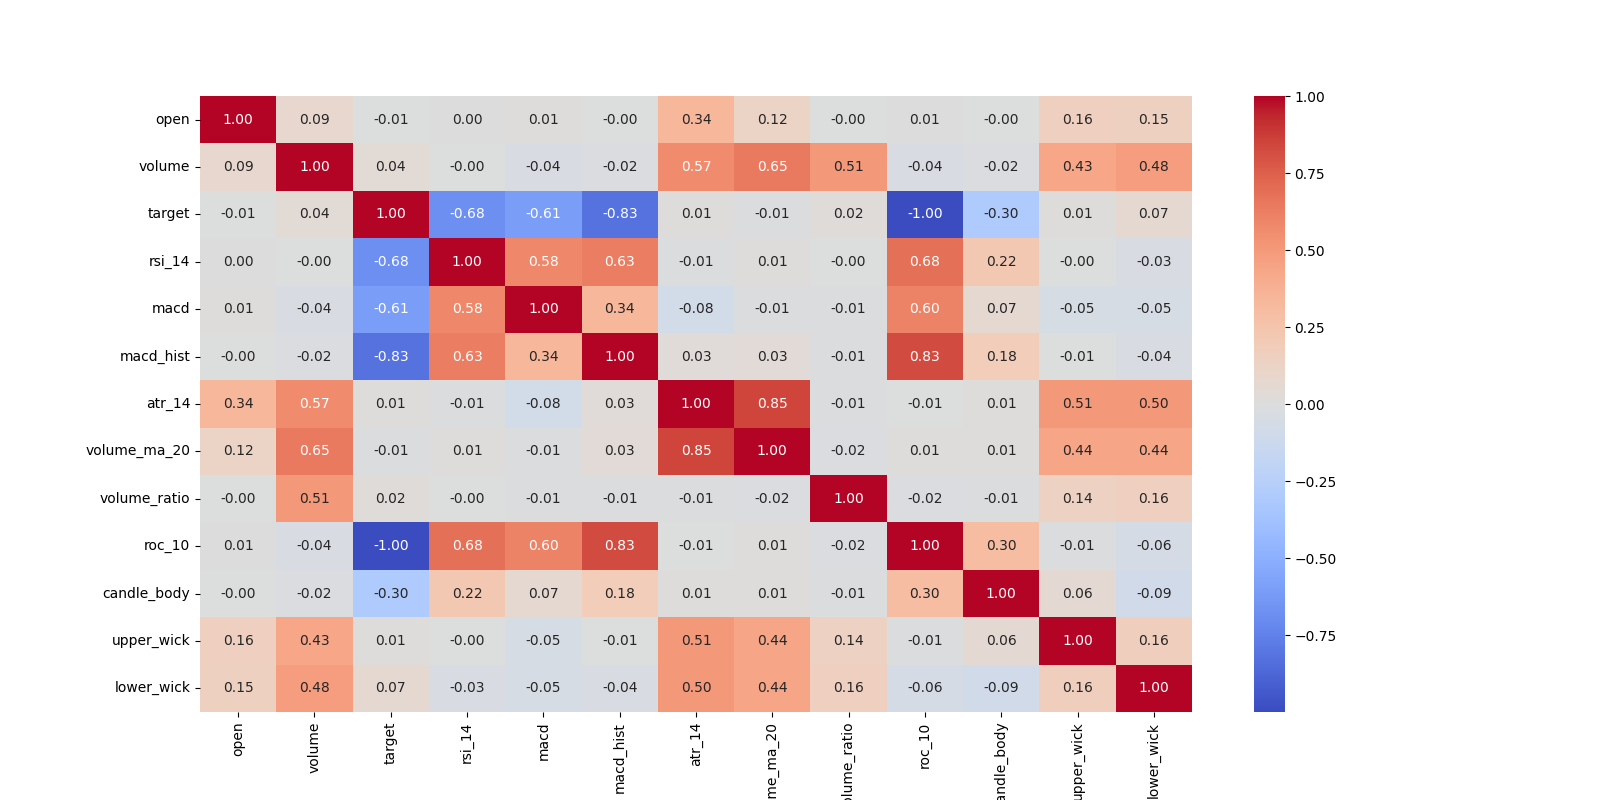

In [39]:
corr_matrix = df_reduced.corr()
plt.figure(figsize=(16, 8))
sns.heatmap(corr_matrix, cmap='coolwarm', annot=True, fmt=".2f")
plt.show()

In [42]:
from xgboost import XGBRegressor
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV

pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Scaling step
    ('regressor', RandomForestRegressor())  # Model
])

# Define hyperparameter grid for the regressor
param_grid = {
    'regressor__n_estimators': [10, 50, 100],
    'regressor__max_depth': [3, 5, 10],
    'regressor__max_features': [5, 10, 15],
    'regressor__bootstrap': [True, False]
}

# Use TimeSeriesSplit for cross-validation
time_series_split = TimeSeriesSplit(n_splits=5)

# Perform grid search with pipeline
grid_search = GridSearchCV(
    pipeline,
    param_grid,
    scoring='neg_mean_squared_error',
    cv=time_series_split,
    return_train_score=True,
    verbose=3
)

# Fit the pipeline
grid_search.fit(X_train_reduced, y_train_reduced)

Fitting 5 folds for each of 54 candidates, totalling 270 fits
[CV 1/5] END regressor__bootstrap=True, regressor__max_depth=3, regressor__max_features=5, regressor__n_estimators=10;, score=(train=-0.005, test=-0.027) total time=   0.3s
[CV 2/5] END regressor__bootstrap=True, regressor__max_depth=3, regressor__max_features=5, regressor__n_estimators=10;, score=(train=-0.008, test=-0.004) total time=   0.7s
[CV 3/5] END regressor__bootstrap=True, regressor__max_depth=3, regressor__max_features=5, regressor__n_estimators=10;, score=(train=-0.008, test=-0.002) total time=   1.0s
[CV 4/5] END regressor__bootstrap=True, regressor__max_depth=3, regressor__max_features=5, regressor__n_estimators=10;, score=(train=-0.008, test=-0.003) total time=   1.3s
[CV 5/5] END regressor__bootstrap=True, regressor__max_depth=3, regressor__max_features=5, regressor__n_estimators=10;, score=(train=-0.006, test=-0.005) total time=   1.8s
[CV 1/5] END regressor__bootstrap=True, regressor__max_depth=3, regressor

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('regressor', RandomForestRegressor())]),
             param_grid={'regressor__bootstrap': [True, False],
                         'regressor__max_depth': [3, 5, 10],
                         'regressor__max_features': [5, 10, 15],
                         'regressor__n_estimators': [10, 50, 100]},
             return_train_score=True, scoring='neg_mean_squared_error',
             verbose=3)

#### Save GridSearch Results

In [46]:

# Save the GridSearchCV object
joblib.dump(grid_search, 'grid_search_results_1min_reduced.pkl')

NameError: name 'grid_search' is not defined

In [ ]:
import cupy as cp
X_train_gpu = cp.array(X_train)
y_train_gpu = cp.array(y_train)


In [ ]:
def simulate_trades_with_penalty(predicted_changes, signals, initial_balance=1000):
    balance = initial_balance
    position = 0
    trades = 0  # Count the number of trades
    penalty = 0  # Initialize penalty for excessive trading

    for change, signal in zip(predicted_changes, signals):
        if signal == "Buy":
            position += balance / 100
            balance = 0
            trades += 1
        elif signal == "Sell" and position > 0:
            balance += position * (1 + change / 100)
            position = 0
            trades += 1
        # "Hold" means do nothing
    
    balance += position * (1 + predicted_changes.iloc[-1] / 100)
    
    # Apply penalty for excessive trades
    penalty = -0.01 * trades  # Example penalty, adjust as needed
    return balance - initial_balance + penalty


In [8]:
import sqlite3
db_name="binance_data.db"
conn = sqlite3.connect(db_name)
cursor = conn.cursor()
cursor.execute("PRAGMA journal_mode=DELETE;")
conn.commit()
conn.close()